This is my analysis of Riverkeeper (www.riverkeeper.org) data on Hudson River Enterococcus levels

First I load data and libraries:

In [1]:
import pandas as p
import seaborn as sns

from ggplot import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [34]:
river_entero = p.read_csv('data/riverkeeper_data_2013.csv')

Let's look at the data:

In [35]:
river_entero[0:5]

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount
0,Hudson above Mohawk River,10/16/2011,1733,1.5,35
1,Hudson above Mohawk River,10/21/2013,4,0.2,35
2,Hudson above Mohawk River,9/21/2013,20,0.0,35
3,Hudson above Mohawk River,8/19/2013,6,0.0,35
4,Hudson above Mohawk River,7/21/2013,31,0.0,35


In [36]:
river_entero.describe()

,FourDayRainTotal,SampleCount
count,3397.000000,3397.000000
mean,0.568001,56.886370
std,1.000387,41.588476
min,0.000000,27.000000
25%,0.000000,37.000000
50%,0.200000,42.000000
75%,0.700000,50.000000
max,8.500000,187.000000


uh oh: python is not recognizing EnteroCount as a numeric field
! Let's fix that

In [37]:
river_entero['Date'] = p.Series(
    [p.to_datetime(d) for d in river_entero['Date']]
)

let's find this bad data

In [38]:
river_entero['EnteroCount'].value_counts()

<10       528
10        289
20        148
2          83
4          78
1          77
3          77
31         65
41         64
6          64
5          63
>2420      59
11         59
12         50
7          47
<1         44
9          41
8          39
30         39
16         35
13         35
19         30
15         30
17         28
52         26
21         25
63         24
22         23
1500       22
>24196     20
         ... 
987         1
290         1
762         1
404         1
4884        1
337         1
1785        1
663         1
100         1
244         1
193         1
2682        1
131         1
2723        1
464         1
1479        1
548         1
106         1
1904        1
359         1
908         1
717         1
263         1
894         1
158         1
1620        1
584         1
1427        1
1110        1
1670        1
Name: EnteroCount, dtype: int64

Ok- it looks like there are four bad values: `<1, <10, >2420, >24196`. We want to adjust them. What should we do? Well: that is tricky. <1 is easy. For <10, we know that the value is bounded 0-10, so one approach would be to randomly select numbers 0-10 (if we were really careful, we could estimate the relative frequency).

For >2420, that is a tougher questions. let's look at what the distribution of >2420 readings looks like:

In [39]:
# Evaluate outliers (entero counts > 2420)
outliers = river_entero.copy()
outliers['EnteroCount'].replace(to_replace='<1', value=0, inplace=True)
outliers['EnteroCount'].replace(to_replace='<10', value=0, inplace=True)
outliers['EnteroCount'].replace(to_replace='>2420', value=0, inplace=True)
outliers['EnteroCount'].replace(to_replace='>24196', value=0, inplace=True)

outliers = outliers[outliers['EnteroCount'].astype('float') > 2420]
outliers['EnteroCount'] = outliers['EnteroCount'].astype('float')

outliers = outliers.reset_index()

In [40]:

#outliers.describe()
outliers.head()

,index,Site,Date,EnteroCount,FourDayRainTotal,SampleCount
0,1562,Peekskill Riverfront Green Park,2011-09-15,4352.0,0.0,42
1,1626,Furnace Brook,2011-05-17,2481.0,2.0,48
2,1630,Furnace Brook,2011-09-15,4106.0,0.0,48
3,1701,Cedar Pond Brook,2011-09-15,2723.0,0.0,47
4,1705,Cedar Pond Brook,2011-05-17,3654.0,2.0,47


/Users/josh.laurito/anaconda/envs/py/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


[(2000, 7000)]

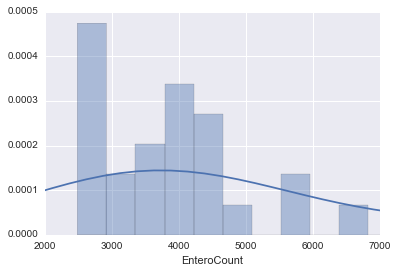

In [41]:
outliers['EnteroCount'] = outliers['EnteroCount'].convert_objects(convert_numeric=True)
#pt = ggplot(outliers,aes(x='EnteroCount')) + geom_histogram(binwidth=100) + xlim(2400, 5000) + ylim(0,100)
#pt
pt = sns.distplot(outliers['EnteroCount'], bins=50)

pt.set(xlim=(2000,7000))

Looks like putting in 3000-4500 is a pretty decent proxy for the rest of our data (though it looks like people just wrote '2500' for high values: probably deserves some more investigation. Let's put in 3750 for now though.


In [42]:
import random
#river_entero['EnteroCount'].replace(to_replace='<1', value=0, inplace=True)
river_entero['EnteroCount'] = river_entero['EnteroCount'].replace(to_replace='<1', value=0)

river_entero['EnteroCount'].replace(to_replace='<10', value=int(10*random.random()), inplace=True)
river_entero['EnteroCount'].replace(to_replace='>2420', value=3750, inplace=True)

In [43]:
river_entero['EnteroCount'] = river_entero['EnteroCount'].convert_objects(convert_numeric=True)

/Users/josh.laurito/anaconda/envs/py/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [44]:
river_entero.describe()

,EnteroCount,FourDayRainTotal,SampleCount
count,3377.000000,3397.000000,3397.000000
mean,268.405389,0.568001,56.886370
std,982.709284,1.000387,41.588476
min,0.000000,0.000000,27.000000
25%,4.000000,0.000000,37.000000
50%,18.000000,0.200000,42.000000
75%,83.000000,0.700000,50.000000
max,24196.000000,8.500000,187.000000


Ok, let's make some graphs - Let's start with an initial chart to see what we are dealing with

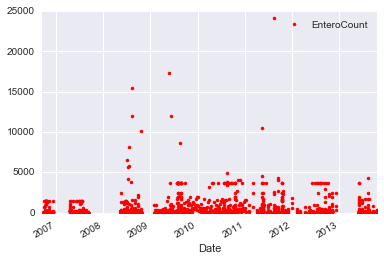

In [45]:

# plot 
river_entero.plot(kind='line', x='Date', y='EnteroCount', style=[' .r'])


/Users/josh.laurito/anaconda/envs/py/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


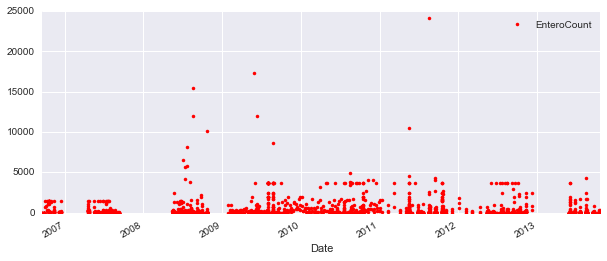

In [46]:
river_entero.sort('Date', inplace=True)

river_entero.plot(
    x='Date', 
    y='EnteroCount', 
    figsize=(10,4),
    style=[' .r'])


# 1. Create lists & graphs of the best and worst places to swim in the dataset.

Given that a single reading over 32 is considered unsafe, we have a really high likelihood of finding locations that do not pass health inspection!

'Best' and 'Worst' are subjective labels. To me, it means that you are *most likely* to have poor conditions that prevent swimming, not that you swim in the absolute lowest quality water. I'm going to look at the likelihood of passing/failing the test, though other methods are ok as well. I'm also only going to look at the past 3 years: an arbitrary cut-off, but I do not think data from 2007 has much importance now.

In [47]:
from datetime import datetime
river_entero['pass_safety'] = river_entero['EnteroCount'] <= 110

In [48]:
river_entero[0:3]

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount,pass_safety
1587,Stony Point mid-channel,2006-09-19,3.0,0.0,44,True
1752,Haverstraw Bay mid-channel,2006-09-19,4.0,0.0,48,True
1799,Croton Point Beach,2006-09-19,2.0,0.0,48,True


In [49]:
from datetime import datetime

site_pass_rate = river_entero[['Site', 
                               'pass_safety', 
                               'EnteroCount']
                              ][river_entero['Date'] >= datetime(2011,1,1)].groupby('Site').mean()

Ok, we have our pass rates.

*For the WORST* let's take the places with the lowest pass rates first, and break ties with the highest average Entero counts first.
*For the BEST* we will do the opposite

In [144]:
worst = site_pass_rate.sort(['pass_safety','EnteroCount'], ascending=[1,0])[0:6]

/Users/josh.laurito/anaconda/envs/py/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [145]:
worst[:]

,pass_safety,EnteroCount
Site,,
Upper Sparkill Creek,0.166667,1659.333333
Mohawk River at Waterford,0.277778,823.500000
Newburgh Launch Ramp,0.444444,348.388889
Dunn Memorial Bridge- Albany,0.500000,532.277778
Saw Mill River,0.526316,1584.555556
Newtown Creek- Metropolitan Ave. Bridge,0.578947,563.000000


In [105]:
best = site_pass_rate.sort(['pass_safety','EnteroCount'], ascending=[0,1])[0:8]

/Users/josh.laurito/anaconda/envs/py/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [106]:
best[:]

,pass_safety,EnteroCount
Site,,
TZ Bridge mid-channel,1.0,5.666667
Haverstraw Bay mid-channel,1.0,8.500000
Yonkers mid-channel,1.0,11.052632
Poughkeepsie Drinking Water Intake,1.0,11.555556
Marlboro Landing,1.0,12.611111
Stony Point mid-channel,1.0,12.611111
Little Stony Point,1.0,12.777778
Cold Spring Harbor,1.0,18.333333


In [107]:
worst_readings = river_entero[river_entero['Site'].isin(worst.index)]
worst_readings = worst_readings[river_entero['Date'] >= datetime(2011,1,1)]

/Users/josh.laurito/anaconda/envs/py/lib/python3.4/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [108]:
worst_readings

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount,pass_safety
2523,Upper Sparkill Creek,2011-01-03,548.0,0.1,165,False
2524,Upper Sparkill Creek,2011-01-11,68.0,0.0,165,True
2510,Upper Sparkill Creek,2011-02-07,146.0,0.4,165,False
2509,Upper Sparkill Creek,2011-03-07,3750.0,2.3,165,False
2508,Upper Sparkill Creek,2011-04-04,225.0,0.2,165,False
2507,Upper Sparkill Creek,2011-05-02,161.0,0.4,165,False
3293,Newtown Creek- Metropolitan Ave. Bridge,2011-05-16,1063.0,1.1,57,False
2577,Saw Mill River,2011-05-17,NaN,1.8,50,False
1329,Newburgh Launch Ramp,2011-05-18,921.0,2.1,38,False
56,Mohawk River at Waterford,2011-05-19,96.0,1.6,35,True


In [109]:
best_readings = river_entero[river_entero['Site'].isin(best.index)]
best_readings = best_readings[river_entero['Date'] >= datetime(2011,1,1)]

/Users/josh.laurito/anaconda/envs/py/lib/python3.4/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


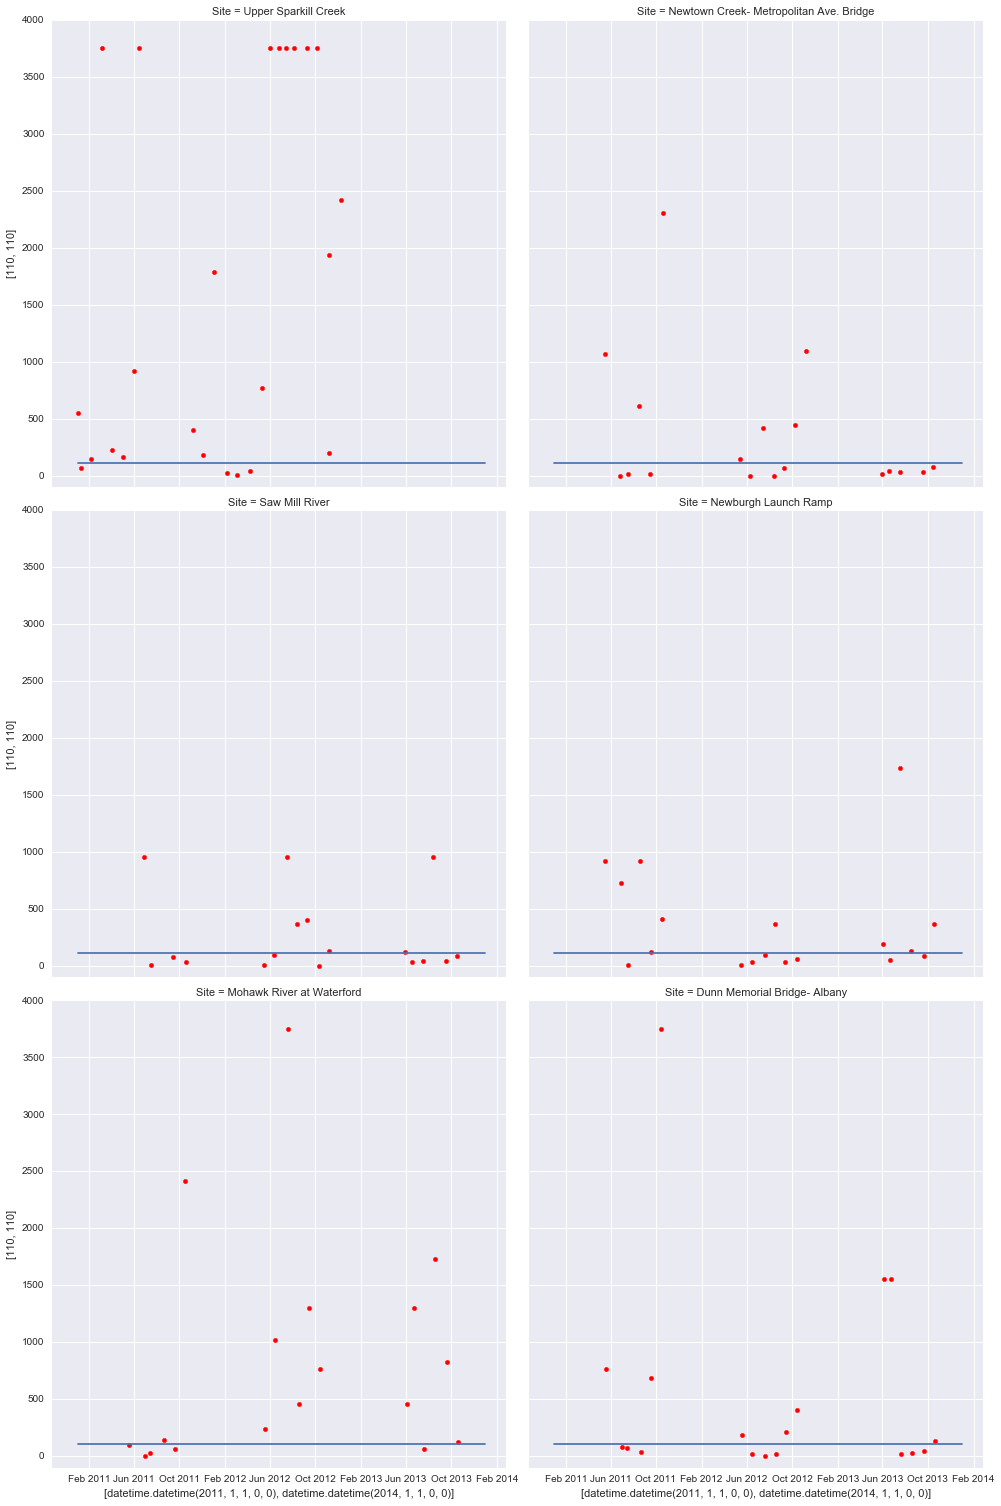

In [146]:

worst_plot = sns.FacetGrid(
    data = worst_readings, 
    col = 'Site',
    col_wrap = 2,
    size = 7,
    ylim = (-100,4000))

worst_plot = (worst_plot.map(plt.scatter,'Date', 'EnteroCount', color='red'))

worst_plot.map_dataframe(plt.plot, [datetime(2011,1,1),datetime(2014,1,1)], [110,110], 'r-')



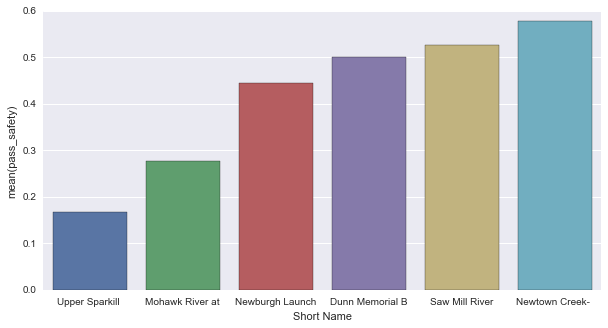

In [147]:
worst['Site_Name'] = worst.index
worst['Short Name'] = worst['Site_Name'].str[0:15]

fig, ax = plt.subplots(figsize = (10,5))

sns.barplot(
    x = 'Short Name',
    y = 'pass_safety',
    data = worst.reset_index()
)

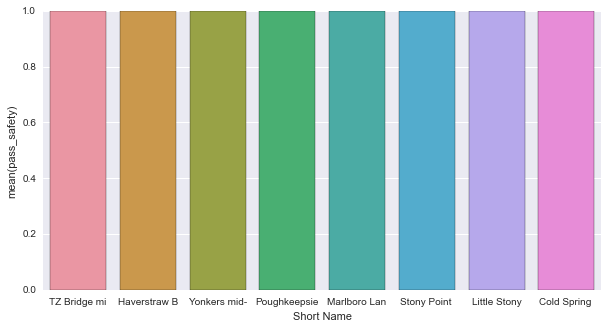

In [148]:
best['Site_Name'] = best.index
best['Short Name'] = best['Site_Name'].str[0:15]

fig, ax = plt.subplots(figsize = (10,5))

sns.barplot(
    x = 'Short Name',
    y = 'pass_safety',
    data = best.reset_index()
)


# 2 The testing of water quality can be sporadic. Which sites have been tested most regularly? Which ones have long gaps between tests? Pick out 5-10 sites and visually compare how regularly their water quality is tested.

Time distance between events is really difficult to convey, especially when we are aggregating data. We'll attempt to handle it using histograms

In [149]:
river_entero.sort(['Site', 'Date'], inplace=True)
river_entero_wq = river_entero.reset_index()


/Users/josh.laurito/anaconda/envs/py/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [150]:
river_entero_wq['days_between_samples'] = river_entero_wq['Date'].diff()
river_entero_wq[60:70]

,index,Site,Date,EnteroCount,FourDayRainTotal,SampleCount,pass_safety,days_between_samples
60,2903,125th St. Pier,2013-05-31,0.0,0.5,66,True,204 days
61,2904,125th St. Pier,2013-06-19,41.0,0.2,66,True,19 days
62,2905,125th St. Pier,2013-07-17,10.0,0.0,66,True,28 days
63,2906,125th St. Pier,2013-08-14,31.0,1.0,66,True,28 days
64,2907,125th St. Pier,2013-09-18,41.0,0.0,66,True,35 days
65,2908,125th St. Pier,2013-10-16,201.0,0.0,66,False,28 days
66,3013,79th St. mid-channel,2006-09-26,0.0,0.1,49,True,-2577 days
67,3012,79th St. mid-channel,2006-10-18,30.0,1.1,49,True,22 days
68,3011,79th St. mid-channel,2006-11-10,143.0,3.6,49,False,23 days
69,3010,79th St. mid-channel,2007-04-18,205.0,8.5,49,False,159 days


In [151]:
from datetime import timedelta

river_entero_wq['days_between_samples'][
    river_entero_wq['days_between_samples'] < timedelta(days=1)
] = None
river_entero_wq[60:70]

/Users/josh.laurito/anaconda/envs/py/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,Site,Date,EnteroCount,FourDayRainTotal,SampleCount,pass_safety,days_between_samples
60,2903,125th St. Pier,2013-05-31,0.0,0.5,66,True,204 days
61,2904,125th St. Pier,2013-06-19,41.0,0.2,66,True,19 days
62,2905,125th St. Pier,2013-07-17,10.0,0.0,66,True,28 days
63,2906,125th St. Pier,2013-08-14,31.0,1.0,66,True,28 days
64,2907,125th St. Pier,2013-09-18,41.0,0.0,66,True,35 days
65,2908,125th St. Pier,2013-10-16,201.0,0.0,66,False,28 days
66,3013,79th St. mid-channel,2006-09-26,0.0,0.1,49,True,NaT
67,3012,79th St. mid-channel,2006-10-18,30.0,1.1,49,True,22 days
68,3011,79th St. mid-channel,2006-11-10,143.0,3.6,49,False,23 days
69,3010,79th St. mid-channel,2007-04-18,205.0,8.5,49,False,159 days


In [152]:
river_entero_wq['days_between_samples'] = river_entero_wq['days_between_samples'].astype('timedelta64[D]')
river_entero_wq = river_entero_wq[np.isfinite(river_entero_wq['days_between_samples'])]


river_entero_wq[60:70]

,index,Site,Date,EnteroCount,FourDayRainTotal,SampleCount,pass_safety,days_between_samples
61,2904,125th St. Pier,2013-06-19,41.0,0.2,66,True,19.0
62,2905,125th St. Pier,2013-07-17,10.0,0.0,66,True,28.0
63,2906,125th St. Pier,2013-08-14,31.0,1.0,66,True,28.0
64,2907,125th St. Pier,2013-09-18,41.0,0.0,66,True,35.0
65,2908,125th St. Pier,2013-10-16,201.0,0.0,66,False,28.0
67,3012,79th St. mid-channel,2006-10-18,30.0,1.1,49,True,22.0
68,3011,79th St. mid-channel,2006-11-10,143.0,3.6,49,False,23.0
69,3010,79th St. mid-channel,2007-04-18,205.0,8.5,49,False,159.0
70,3009,79th St. mid-channel,2007-05-23,3.0,0.0,49,True,35.0
71,3008,79th St. mid-channel,2007-06-18,1.0,0.0,49,True,26.0


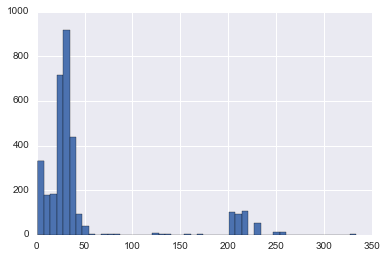

In [153]:

river_entero_wq['days_between_samples'].hist(bins=50)

It looks like there are two patterns of sampling: every month and about every 7 months (probably for places that are likely to freeze!) Let's compare a couple of places

In [155]:
new_worst = river_entero_wq[river_entero['Site'].isin(worst.index)]
new_worst['Site'].value_counts()


/Users/josh.laurito/anaconda/envs/py/lib/python3.4/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Piermont Pier                         149
West Point STP Outfall                 35
125th St. Pier                         31
Athens                                 29
Poughkeepsie Drinking Water Intake     27
Port Ewen Drinking Water Intake        22
Haverstraw Bay mid-channel             22
Yonkers STP Outfall                    16
Harlem River- Willis Ave. Bridge       15
Pier 96 Kayak Launch                   15
Annesville Creek                        8
Wappingers Creek                        4
79th St. mid-channel                    3
Name: Site, dtype: int64

In [156]:
new_worst = new_worst[(new_worst['Site']=='Piermont Pier')|
                      (new_worst['Site']=='West Point STP Outfall')|
                      (new_worst['Site']=='125th St. Pier')|
                      (new_worst['Site']=='Athens')|
                      (new_worst['Site']=='Poughkeepsie Drinking Water Intake')|
                      (new_worst['Site']=='Haverstraw Bay mid-channel')]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1287ce940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x129369b00>]], dtype=object)

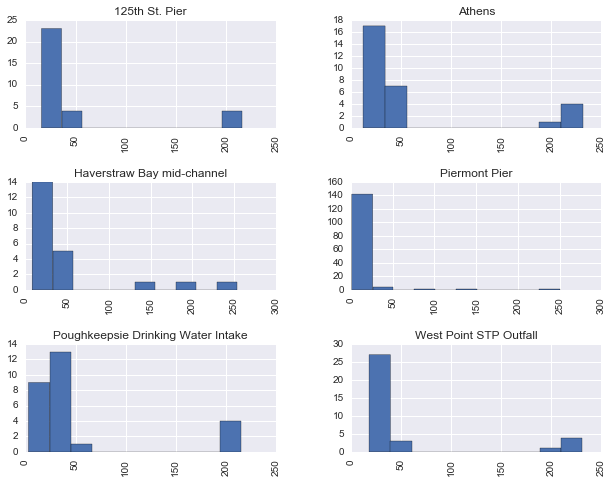

In [160]:
#ggplot(new_worst, aes(x='days_between_samples')) + \
#geom_histogram(binwidth=10) + facet_wrap('Site') + xlim(0,300)

new_worst[['Site','days_between_samples']].hist(by = 'Site', figsize= (10,8))

# 3 Is there a relationship between the amount of rain and water quality?  Show this relationship graphically. If you can, estimate the effect of rain on quality at different sites and create a visualization to compare them

classic scatterplot question: comparing two values to find a relationship

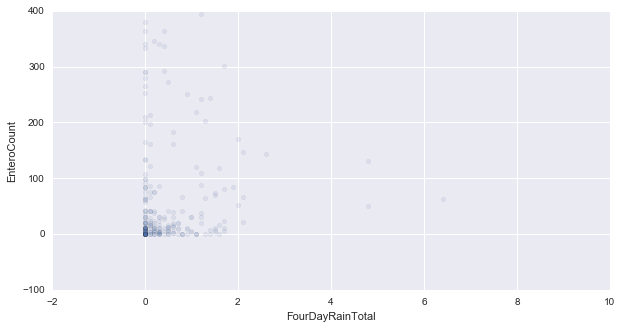

In [165]:
new_worst.reset_index().plot(
    kind = 'scatter',
    x = 'FourDayRainTotal',
    y = 'EnteroCount',
    alpha = 0.1,
    ylim = (-100,400),
    figsize = (10,5)
)

Lots of problems here: too much data, overplotting. We can take medians by bin

In [166]:
new_worst['rainfall_bin'] = (4 * new_worst['FourDayRainTotal']).round()/4

In [167]:
rain_sum = new_worst.groupby('rainfall_bin').median()
rain_sum['rainfall'] = rain_sum.index
rain_sum

,index,EnteroCount,FourDayRainTotal,SampleCount,pass_safety,days_between_samples,rainfall
rainfall_bin,,,,,,,
0.00,2117.0,30.0,0.00,187.0,True,9.0,0.00
0.25,2084.5,10.0,0.25,66.0,True,24.5,0.25
0.50,2133.0,15.5,0.50,66.0,True,27.0,0.50
0.75,1921.5,15.0,0.75,57.0,True,15.5,0.75
1.00,2229.0,20.0,1.00,66.0,True,26.5,1.00
1.25,2136.0,110.0,1.20,187.0,True,7.0,1.25
1.50,1920.0,43.0,1.50,117.5,True,13.0,1.50
1.75,2226.0,23.0,1.70,187.0,True,3.0,1.75
2.00,2099.0,147.0,2.00,66.0,False,36.0,2.00


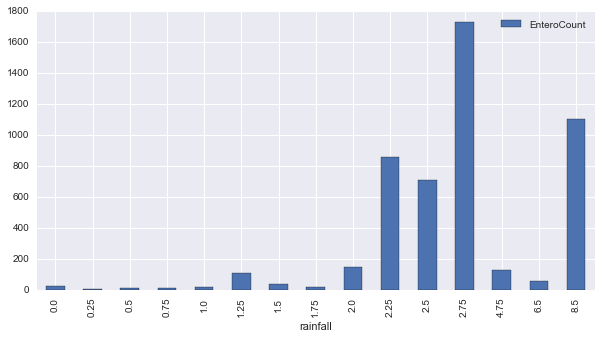

In [169]:
#ggplot(rain_sum,aes(x='rainfall', y='EnteroCount')) + geom_bar(aes(weight='EnteroCount', fill='blue'))

rain_sum.plot(
    kind = 'bar',
    x = 'rainfall',
    y = 'EnteroCount',
    figsize = (10,5)
)

wow: that's noticable. The median Entero count goes way up after 2 inches of rain, with spikes once it gets over 2 inches. It is unclear whether those are outliers though: let's dig in more.

In [178]:
rain_sum_site = new_worst.groupby(['Site','rainfall_bin']).median()
rain_sum_site['rainfall'] = rain_sum_site.index.get_level_values('rainfall_bin')
rain_sum_site['Site'] = rain_sum_site.index.get_level_values('Site')
rain_sum_site[20:28]

index  EnteroCount  \
Site                       rainfall_bin                        
Haverstraw Bay mid-channel 0.75          1733.5          4.5   
                           1.00          1739.0          0.0   
                           1.50          1749.0          8.0   
                           1.75          1741.0          5.0   
Piermont Pier              0.00          2180.5        146.5   
                           0.25          2127.0         20.0   
                           0.50          2205.5        101.0   
                           0.75          2155.5        391.0   

                                         FourDayRainTotal  SampleCount  \
Site                       rainfall_bin                                  
Haverstraw Bay mid-channel 0.75                      0.75         48.0   
                           1.00                      1.10         48.0   
                           1.50                      1.50         48.0   
                           1.75                      1.70         48.0   
Piermont Pier              0.00                      0.00        187.0   
                           0.25                      0.20        187.0   
                           0.50                      0.55        187.0   
                           0.75                      0.70        187.0   

                                         pass_safety  days_between_samples  \
Site                       rainfall_bin                                      
Haverstraw Bay mid-channel 0.75                  1.0                  20.5   
                           1.00                  1.0                  20.0   
                           1.50                  1.0                  34.5   
                           1.75                  1.0                  27.0   
Piermont Pier              0.00                  0.0                   7.0   
                           0.25                  1.0                   7.0   
                           0.50                  0.5                   6.5   
                           0.75                  0.5                   6.5   

                                         rainfall                        Site  
Site                       rainfall_bin                                        
Haverstraw Bay mid-channel 0.75              0.75  Haverstraw Bay mid-channel  
                           1.00              1.00  Haverstraw Bay mid-channel  
                           1.50              1.50  Haverstraw Bay mid-channel  
                           1.75              1.75  Haverstraw Bay mid-channel  
Piermont Pier              0.00              0.00               Piermont Pier  
                           0.25              0.25               Piermont Pier  
                           0.50              0.50               Piermont Pier  
                           0.75              0.75               Piermont Pier

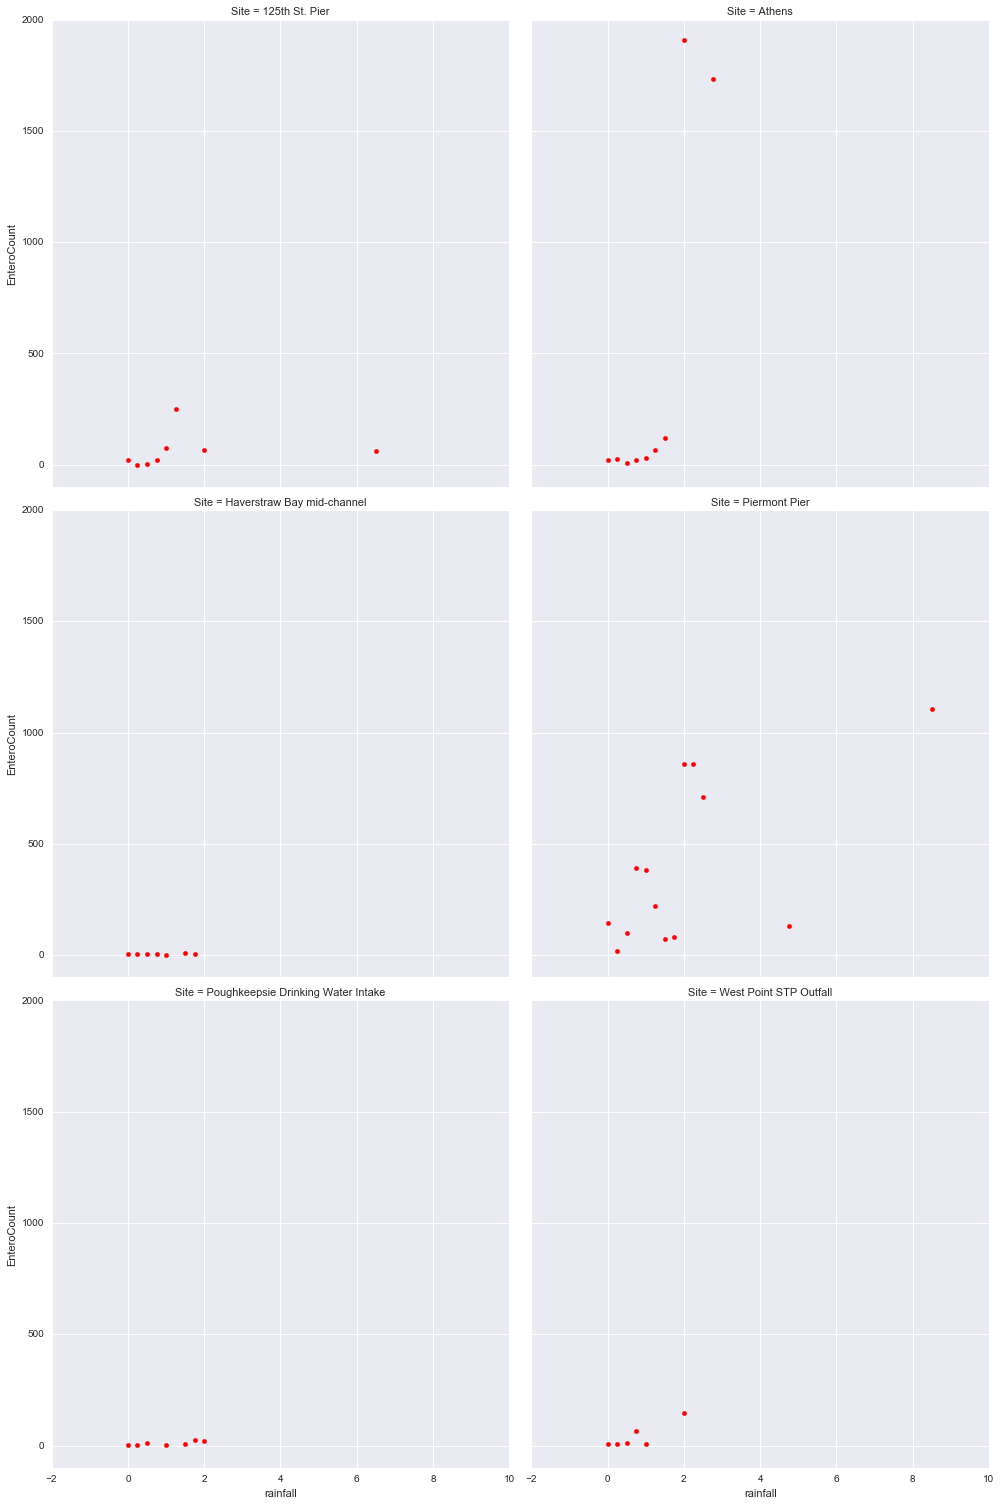

In [183]:
# p4 = ggplot(rain_sum_site, aes(x='rainfall', y='EnteroCount')) + geom_point() 
# p4 + scale_x_continuous() + geom_vline(x=9, color='white') + facet_wrap('Site') + xlim(0,6) 

# rain_sum_site[['rainfall','Site', 'EnteroCount']].plot(
#     by = 'Site',
#     kind = 'scatter',
#     x = 'rainfall',
#     y = 'EnteroCount',
#     subplots = True

# )

rain_plot = sns.FacetGrid(
    data = rain_sum_site, 
    col = 'Site',
    col_wrap = 2,
    size = 7,
    ylim = (-100,2000)
)

rain_plot = (rain_plot.map(plt.scatter,'rainfall', 'EnteroCount', color='red'))


It's unclear if there is a local peak at 2-2.5 inches of rain: needs more research